# Tensorflow로 DeepFM 구현
- tensorflow keras를 활용하여 DeepFM을 구현합니다
- DNN, FM Layer는 따로 Custom Layer로 만들어준 뒤 최종 DeepFM tensorflow 모델에서 합쳐줍니다
- 현재 모델 구조에서 각 Layer별로 다양한 옵션을 줄 수 있습니다 (l2 regularization, dropout, batch normalization 등)

In [9]:
from collections import OrderedDict, defaultdict
from copy import copy
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm
from tensorflow.python.client import device_lib
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16056250620282814463
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2969774158312672999
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
# Feature 클래스
# 필드별로 이름 및 feature의 최대 개수(size) 선언
# ex) 성별 --> 남자, 여자 --> size=2

class Feature:

  def __init__(self, name, size):
    self.name = name
    self.size = size

In [5]:
# FM Custom Layer
class FM(tf.keras.layers.Layer):
  '''
  Input shape : (batch_size, field_size, embedding_size)
  Output shape : (batch_size, 1)
  '''
  
  def __init__(self, **kwargs):
    super(FM, self).__init__(**kwargs)
  
  def build(self, input_shape):

    if len(input_shape) != 3:
      raise ValueError(f'Unexpected inputs dimensions {len(input_shape)}, expect to be 3 dimensions')
    
    super(FM, self).build(input_shape)
  
  def call(self, inputs, **kwargs):

    square_of_sum = tf.square(tf.reduce_sum(inputs, axis=1, keepdims=True))
    sum_of_square = tf.reduce_sum(inputs * inputs, axis=1, keepdims=True)
    cross_term = square_of_sum - sum_of_square
    cross_term = 0.5 * tf.reduce_sum(cross_term, axis=2, keepdims=False)

    return cross_term
  
  def compute_output_shape(self, input_shape):
    return (None, 1)

In [ ]:
# FM Custom Layer

class FM(tf.keras.layers.Layer):
    """
      Input shape
      - 3D tensor with shape: ``(batch_size, field_size, embedding_size)``.
      Output shape
      - 2D tensor with shape: ``(batch_size, 1)``.
    """

    def __init__(self, **kwargs):
        super(FM, self).__init__(**kwargs)

    def build(self, input_shape):
        
        if len(input_shape) != 3:
            raise ValueError("Unexpected inputs dimensions % d, expect to be 3 dimensions" % (len(input_shape)))
        
        super(FM, self).build(input_shape)

    def call(self, inputs, **kwargs):
        
        square_of_sum = tf.square(tf.reduce_sum(inputs, axis=1, keepdims=True))
        sum_of_square = tf.reduce_sum(inputs * inputs, axis=1, keepdims=True)
        cross_term = square_of_sum - sum_of_square
        cross_term = 0.5 * tf.reduce_sum(cross_term, axis=2, keepdims=False)
        
        return cross_term

    def compute_output_shape(self, input_shape):
        return (None, 1)

In [17]:
from tensorflow.python.ops.init_ops_v2 import Initializer
# DNN Custom Layer
class DNN(tf.keras.layers.Layer):
  '''
  input_shape = (batch_size, input_dim)
  output_shape = (batch_size, hidden_size[-1])
  '''

  def __init__(self, hidden_units, activation='relu', dropout_rate=0, seed=256, **kwargs):
    self.hidden_units = hidden_units
    self.activation = activation
    self.dropout_rate = dropout_rate
    self.seed = seed

    super(DNN, self).__init__(**kwargs)

  def build(self, input_shape):

    if len(self.hidden_units) == 0:
      raise ValueError('hidden_units is empty')
    
    # DNN Layer는 각 hidden layer의 weight & bias를 학습 파라미터로 선언
    input_size = input_shape[-1]
    hidden_units = [int(input_size)] + list(self.hidden_units)
    self.kernels = [self.add_weight(name='kernel' + str(i),
                                    shape=(hidden_units[i], hidden_units[i+1]),
                                    initializer=tf.keras.initializers.glorot_normal(),
                                    trainable=True)
                    for i in range(len(self.hidden_units))]
    self.bias = [self.add_weight(name='bias' + str(i),
                                 shape=(self.hidden_units[i],),
                                 initializer=tf.keras.initializers.Zeros(),
                                 trainable=True)
                for i in range(len(self.hidden_units))]

    self.dropout_layers = [tf.keras.layers.Dropout(self.dropout_rate, seed=self.seed + i, name='dropout' + str(i),
                                                   ) for i in range(len(self.hidden_units))]
    self.activation_layers = [tf.keras.layers.Activation(self.activation) for _ in range(len(self.hidden_units))]

    super(DNN, self).build(input_shape)
  

  def call(self, inputs, training=None, **kwargs):
    deep_input = inputs

    # hidden_layer의 개수만큼 루프를 돌며 layer를 계속 쌓아줌
    for i in range(len(self.hidden_units)):
      fc = tf.nn.bias_add(tf.tensordot(deep_input, self.kernels[i], axes=(-1, 0)), self.bias[i])
      fc = self.activation_layers[i](fc)
      fc = self.dropout_layers[i](fc, training=training)
      deep_input = fc
    
    return deep_input
  
  def compute_output_shape(self, input_shape):
    if len(self.hidden_units) > 0:
      shape=input_shape[:-1] + (self.hidden_units[-1], )
    
    else:
      shape=input_shape
    
    return tuple(shape)
  
  def get_config(self):
    config = {'activation' : self.activation, 'hidden_units' : self.hidden_units}
    base_config = super(DNN, self).get_config()
    return dict(list(base_config.items()) + list(config.itemse()))

## DeepFM Tensorflow 모델

In [22]:
def DeepFM(feature_columns, embedding_dim=4, dnn_hidden_units=(64,32), 
           activation='relu', dropout_rate=0, name='DeepFM'):
  
  '''
  feature 별로 tensorflow keras의 input을 선언
  feature 별로 하나의 값을 가지므로 shape=(1,)
  '''
  input_dict = OrderedDict()
  
  for feat in feature_columns:
    input_dict[feat.name] = tf.keras.layers.Input(shape=(1,), name=feat.name)
  
  # feature들을 모델의 input으로 사용
  inputs = list(input_dict.values())

  # DeepFM의 linear한 1-order weight를 곱해서 더함
  # feature별로 1차원 embedding matrix를 선언하며, 이것이 linear interaction의 역할도 함
  linears = [tf.keras.layers.Embedding(feat.size, 1, 
                                       embeddings_initializer=tf.keras.initializers.RandomNormal(),
                                       trainable=True,
                                       name='linear_' + feat.name)(input_dict[feat.name])
                                       ]
  
  linear_sum = tf.keras.layers.add(linears, name='linear_sum')
  linear_logit = tf.keras.layers.Flatten(name='linear_logit')(linear_sum)


  # 개별 feature의 input을 임베딩
  # 개별 feature에 대해 동일한 차원으로 embeddingi matrix를 선언 후, FM Layer와 DNN Layer의 input으로 사용되게 함
  embeddings = [tf.keras.layers.Embedding(feat.size, embedding_dim,
                                          embeddings_initializer=tf.keras.initializers.RandomNormal(),
                                          trainable=True,
                                          name='emb_' + feat.name)(input_dict[feat.name]) for feat in feature_columns
                ]
  
  # DeepFM의 2-order feature interaction을 계산해서 더함 
  fm_input = tf.keras.layers.Concatenate(axis=1, name='fm_input')(embeddings)
  fm_logit = FM(name='fm_logit')(fm_input)

  # DeepFM의 high-order interaction인 dnn layer를 선언해 dnn_output과 dnn_logit을 계산
  embeddings_concat = tf.keras.layers.Concatenate(axis=-1, name='embeddings_concat')(embeddings)
  dnn_input = tf.keras.layers.Flatten(name='dnn_input')(embeddings_concat)
  dnn_output = DNN(hidden_units=dnn_hidden_units, activation=activation,
                   dropout_rate=dropout_rate, name='dnn_output')(dnn_input)
  dnn_logit = tf.keras.layers.Dense(1,
                                    use_bias=True,
                                    kernel_initializer=tf.keras.initializers.glorot_normal(),
                                    name='dnn_logit')(dnn_output)
              
  # linear, fm, dnn의 output을 모두 더한 댜음 sigmoid 통과시킴
  # --> 0~1 사이의 CTR 값 출력
  final_logit = tf.keras.layers.add([linear_logit, fm_logit, dnn_logit], name='final_logit')
  output = tf.keras.layers.Activation('sigmoid', name='sigmoid')(final_logit)

  model = tf.keras.models.Model(inputs=inputs, outputs=output, name=name)
  return model

# DeepFM으로 CTR 예측하기

## 데이터 Preprocessing

In [8]:
file_path = '/content/drive/MyDrive/recomm_study/recomm_code/Recommend_learningspoons/data/avazu-ctr-prediction-20220921T022743Z-001/avazu-ctr-prediction/ad_click.csv'
parse_date = lambda x : datetime.strptime(x, '%y%m%d%H').strftime('%Y-%m-%d')
click_df = pd.read_csv(file_path, parse_dates = ['datetime'], date_parser = parse_date, header=0)
click_df = click_df[[
    'click', 'datetime', 'banner_pos', 'site_id', 'site_domain',
    'site_category', 'app_id', 'app_domain', 'app_category',
    'device_model', 'device_type', 'device_conn_type',
    'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
]]
click_df.head()

,click,datetime,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_conn_type,C1,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,0,da79c793,71ed77a0,f028772b,ecad2386,7801e8d9,07d7df22,fce66524,...,0,1005,18993,320,50,2161,0,35,-1,157
1,0,2014-10-21,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,0f2161f8,1df52df3,...,0,1010,21665,320,50,2493,3,35,-1,117
2,0,2014-10-21,0,61a8c644,948ff336,50e219e0,ecad2386,7801e8d9,07d7df22,72dab84d,...,0,1002,19665,320,50,2253,2,303,-1,52
3,1,2014-10-21,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,8a4875bd,...,0,1005,15706,320,50,1722,0,35,-1,79
4,0,2014-10-21,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,cdfde03b,...,0,1005,20362,320,50,2333,0,39,-1,157


In [11]:
# category컬럼에 대한 labelencoding
features = [
    'banner_pos', 'site_id', 'site_domain','site_category', 'app_id', 'app_domain',
    'app_category', 'device_model', 'device_type', 'device_conn_type',
    'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
]

click_df[features] = click_df[features].fillna('-1')
target=['click']

for feat in features:
  le = LabelEncoder()
  click_df[feat] = le.fit_transform(click_df[feat])

feature_columns = [Feature(feat, click_df[feat].max() + 1) for i, feat in enumerate(features)]

In [12]:
for feature in feature_columns:
    print(feature.name + ':', feature.size)

banner_pos: 7
site_id: 1804
site_domain: 1711
site_category: 20
app_id: 1776
app_domain: 112
app_category: 22
device_model: 3751
device_type: 4
device_conn_type: 4
C1: 7
C14: 1934
C15: 8
C16: 9
C17: 405
C18: 4
C19: 65
C20: 159
C21: 60


In [13]:
click_df

,click,datetime,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_conn_type,C1,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,0,1546,767,18,1648,43,0,3696,...,0,2,375,3,2,102,0,2,0,42
1,0,2014-10-21,1,949,1316,5,965,43,3,441,...,0,5,719,3,2,196,3,2,0,39
2,0,2014-10-21,0,706,1001,5,1648,43,0,1676,...,0,1,410,3,2,116,2,21,0,15
3,1,2014-10-21,1,1541,1029,18,1648,43,0,2011,...,0,2,202,3,2,51,0,2,0,22
4,0,2014-10-21,0,617,1338,3,1648,43,0,3004,...,0,2,515,3,2,144,0,4,0,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,2014-10-30,1,647,604,18,1648,43,0,1272,...,0,2,1771,3,2,378,3,8,0,6
199996,0,2014-10-30,0,949,1316,5,564,91,3,2240,...,0,2,759,3,2,201,3,5,81,16
199997,0,2014-10-30,0,217,1620,1,1648,43,0,235,...,0,2,1272,3,2,294,0,2,0,14
199998,0,2014-10-30,0,1361,1251,5,1648,43,0,121,...,0,1,291,3,2,91,2,4,56,7


## DeepFM 모델 학습

In [23]:
# 날짜를 기준으로 train과 test 데이터를 나눕니다

train_df = click_df[click_df['datetime'] <= '2014-10-28']
test_df = click_df[click_df['datetime'] > '2014-10-28']

train_X = {name:train_df[name].values for name in features}
train_y = train_df[target].values
test_X = {name:test_df[name].values for name in features}
test_y = test_df[target].values

model = DeepFM(feature_columns, embedding_dim=20, dnn_hidden_units=(200, 200), activation='relu',
               dropout_rate=0)
model.compile('adam', 'binary_crossentropy')
model.summary()

Model: "DeepFM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 C21 (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 banner_pos (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 site_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 site_domain (InputLayer)       [(None, 1)]          0           []                               
                                                                                             

In [24]:
history = model.fit(train_X, train_y,
                    batch_size=64, epochs=10, verbose=1, validation_data=(test_X, test_y))

Epoch 1/10
2501/2501 [==============================] - 49s 17ms/step - loss: 0.4136 - val_loss: 0.4042
Epoch 2/10
2501/2501 [==============================] - 40s 16ms/step - loss: 0.3947 - val_loss: 0.4061
Epoch 3/10
2501/2501 [==============================] - 47s 19ms/step - loss: 0.3816 - val_loss: 0.4112
Epoch 4/10
2501/2501 [==============================] - 38s 15ms/step - loss: 0.3697 - val_loss: 0.4210
Epoch 5/10
2501/2501 [==============================] - 37s 15ms/step - loss: 0.3581 - val_loss: 0.4343
Epoch 6/10
2501/2501 [==============================] - 37s 15ms/step - loss: 0.3472 - val_loss: 0.4472
Epoch 7/10
2501/2501 [==============================] - 37s 15ms/step - loss: 0.3368 - val_loss: 0.4587
Epoch 8/10
2501/2501 [==============================] - 39s 16ms/step - loss: 0.3265 - val_loss: 0.4843
Epoch 9/10
2501/2501 [==============================] - 39s 15ms/step - loss: 0.3173 - val_loss: 0.5102
Epoch 10/10
2501/2501 [==============================] - 37s 15m

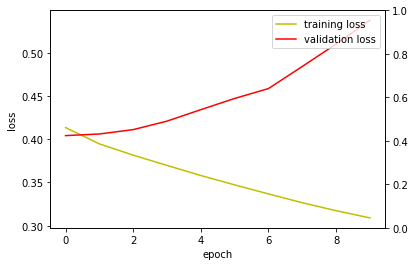

In [25]:
# training loss와 validation loss

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='training loss')
loss_ax.plot(history.history['val_loss'], 'r', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

plt.show()

## DeepFM 모델 예측 및 평가

In [29]:
# epoch = 1로 하여 최종 모델을 학습함

model = DeepFM(feature_columns, embedding_dim = 20, dnn_hidden_units=(200, 200), activation='relu', dropout_rate=0.1)
model.compile("adam", "binary_crossentropy")
model.fit(train_X, train_y, batch_size=64, epochs=1, verbose=1, validation_data=(test_X, test_y))

2501/2501 [==============================] - 40s 15ms/step - loss: 0.4143 - val_loss: 0.4021


In [30]:
pred = model.predict(test_X, batch_size=256)
print("test LogLoss", round(log_loss(test_y, pred), 4))
print("test AUC", round(roc_auc_score(test_y, pred), 4))

157/157 [==============================] - 1s 4ms/step
test LogLoss 0.4021
test AUC 0.722
